In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import torch.nn.init as init





import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")

GPU is available!


In [2]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    with h5py.File(file_path, 'r') as h5f:
        images = [h5f[img_name]["hist"][:].T[:,0:750] for img_name in h5f.keys()]
        npulses = [h5f[img_name].attrs['npulses'] for img_name in h5f.keys()]
    scaler = MinMaxScaler(feature_range=(-1,1))
    for i in range(len(images)):
        images[i] = scaler.fit_transform(images[i])
    return images,npulses,scaler


def create_sequences_and_targets(images, pulse_counts, threshold = 3):
    sequences = []
    targets = []

    # Define the classes for classification
    classes = ["0", "1", "2", "3", "beyond"]

    # Encode the classes
    label_encoder = LabelEncoder()
    label_encoder.fit(classes)

    for i in range(len(images)):
        # The last element in the sequence is the target label
        target = pulse_counts[i]

        # Map the pulse counts into classes
        if target <= threshold:
            target_class = label_encoder.transform([f"{target}"])[0]
        else:
            target_class = label_encoder.transform(["beyond"])[0]

        targets.append(target_class)

    sequences = torch.tensor(images, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.long)

    dataset = TensorDataset(sequences, targets)
    
    return dataset

class PulseClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout = 0):
        super(PulseClassificationLSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers  # Define the num_layers attribute
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    
        # Add dropout layers between LSTM layers
        self.dropout = nn.Dropout(dropout)
        
        # Define the output (classification) layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply dropout
        out = self.dropout(out)
        
        # Get the output from the final time step and pass it through the classification layer
        out = self.fc(out[:, -1, :])
        return out


class PulseClassificationLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.0):
        super(PulseClassificationLSTM2, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Add dropout layers between LSTM layers
        self.dropout = nn.Dropout(dropout)

        # Define the output (classification) layer
        self.fc = nn.Linear(2 * hidden_size, num_classes)  # 2 * hidden_size for bidirectional LSTM
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

        # Initialize weights and biases
        self.init_weights()

    def init_weights(self):
        # Initialize LSTM weights using Xavier initialization
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.xavier_normal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Initialize linear layer weights
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply dropout
        out = self.dropout(out)
        
        # Get the output from the final time step and pass it through the classification layer
        out = self.fc(out[:, -1, :])
        
        # Apply softmax activation for multi-class classification
        out = self.softmax(out)
        
        return out



In [3]:
# Hyperparameters
batch_size = 32 #32
num_epochs = 200
num_classes = 5
learning_rate = 0.001#0.0005
input_size = 750
hidden_size = 128



In [5]:
# Load and preprocess data
#data_file = '../lstm_data2_simdata.h5'  # Replace with the actual path to your HDF5 file
#data_file = '/sdf/group/lcls/ds/scratch/jhirschm/MRCO_Sim_Data/Oct3_2023_simdata.h5'
data_file = '/sdf/group/lcls/ds/scratch/jhirschm/MRCO_Sim_Data/Oct12_2023_simdata.h5'
images,npulses, scaler = load_and_preprocess_data(data_file) #check and good

# # Create sequences and targets
dataset = create_sequences_and_targets(images,npulses, threshold =3)


<ipython-input-2-73f8b0a70a7c>:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)
  sequences = torch.tensor(images, dtype=torch.float32)


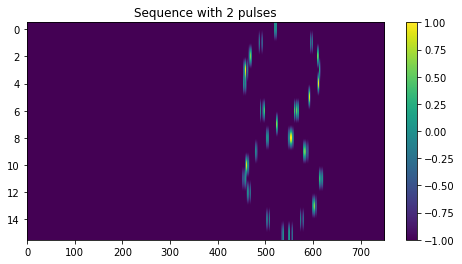

In [8]:
# Function to decode class labels back to pulse counts
def decode_class(class_idx):
    classes = ["0 pulses", "1 pulse", "2 pulses", "3 pulses", "more pulses"]
    return classes[class_idx]

# Choose an example from the dataset
example_idx = 99  # Change this to the index of the example you want to view

sequence, target = dataset[example_idx]

# Decode the class label to get pulse count information
pulse_count = decode_class(target.item())

# Plot the sequence
plt.figure(figsize=(8, 4))
plt.imshow(sequence.numpy(), aspect='auto')
plt.title(f"Sequence with {pulse_count}")
plt.colorbar()
plt.show()

In [9]:
# # Create DataLoader
train_size = int(0.8 * len(dataset))
val_size = int((len(dataset) - train_size) // 1.5)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [13]:
# import pickle

# # Save DataLoaders and datasets
# pre = "/sdf/group/lcls/ds/scratch/jhirschm/MRCO_Sim_Data/Oct3_2023_"
# name = pre + 'train_dataloader.pkl'
# with open(name, 'wb') as file:
#     pickle.dump(train_dataloader, file)
# name = pre + 'val_dataloader.pkl'
# with open(name, 'wb') as file:
#     pickle.dump(val_dataloader, file)
# name = pre + 'test_dataloader.pkl'
# with open(name, 'wb') as file:
#     pickle.dump(test_dataloader, file)
# name = pre + 'train_dataset.pkl'
# with open(name, 'wb') as file:
#     pickle.dump(train_dataset, file)
# name = pre + 'val_dataset.pkl'
# with open(name, 'wb') as file:
#     pickle.dump(val_dataset, file)
# name = pre + 'test_dataset.pkl'
# with open(name, 'wb') as file:
#     pickle.dump(test_dataset, file)




In [4]:
# import pickle

# # To load DataLoaders and datasets
# pre = "/sdf/group/lcls/ds/scratch/jhirschm/MRCO_Sim_Data/Oct3_2023_"

# name = pre + 'train_dataloader.pkl'
# with open(name, 'rb') as file:
#     train_dataloader = pickle.load(file)
# name = pre + 'val_dataloader.pkl'
# with open(name, 'rb') as file:
#     val_dataloader = pickle.load(file)
# name = pre + 'test_dataloader.pkl'
# with open(name, 'rb') as file:
#     test_dataloader = pickle.load(file)
# name = pre + 'train_dataset.pkl'
# with open(name, 'rb') as file:
#     train_dataset = pickle.load(file)
# name = pre + 'val_dataset.pkl'
# with open(name, 'rb') as file:
#     val_dataset = pickle.load(file)
# name = pre + 'test_dataset.pkl'
# with open(name, 'rb') as file:
#     test_dataset = pickle.load(file)

In [10]:
# # Initialize the model
#model = PulseClassificationLSTM2(input_size, hidden_size, num_classes, num_layers=1)
#model = PulseClassificationLSTM(input_size, hidden_size, num_classes, num_layers=2)
model = PulseClassificationLSTM(input_size, hidden_size, num_classes, num_layers=3,dropout=0)

model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Lists to store training and validation losses for later plotting
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
early_stopping_counter = 0
best_val_loss = float('inf')
best_model = None

# Learning rate scheduling
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0

    for batch in train_dataloader:
        optimizer.zero_grad()  # Zero the parameter gradients

        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

    torch.save(model.state_dict(), 'lstm_pulseClassifier_checkpoint.pth')
    
    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        best_model = copy.deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping: No improvement in validation loss for {} epochs.".format(patience))
        break  # Stop training

# Load the best model
if best_model is not None:
    model.load_state_dict(best_model)

Epoch [1/200] - Train Loss: 1.5624464517, Validation Loss: 1.5635457662
Epoch [2/200] - Train Loss: 0.6765929990, Validation Loss: 0.4321870833
Epoch [3/200] - Train Loss: 0.4187792579, Validation Loss: 0.4252814798
Epoch [4/200] - Train Loss: 0.3987740357, Validation Loss: 0.3155277534
Epoch [5/200] - Train Loss: 0.3867320027, Validation Loss: 0.4713705089
Epoch [6/200] - Train Loss: 0.3385326948, Validation Loss: 0.2875060764
Epoch [7/200] - Train Loss: 0.3314535465, Validation Loss: 0.3524675087
Epoch [8/200] - Train Loss: 0.3038483309, Validation Loss: 0.3131515050
Epoch [9/200] - Train Loss: 0.3006202712, Validation Loss: 0.2354214133
Epoch [10/200] - Train Loss: 0.2943942785, Validation Loss: 0.2390035403
Epoch [11/200] - Train Loss: 0.2836770048, Validation Loss: 0.2312722971
Epoch [12/200] - Train Loss: 0.2799411609, Validation Loss: 0.2336778210
Epoch [13/200] - Train Loss: 0.2747803024, Validation Loss: 0.2413284710
Epoch [14/200] - Train Loss: 0.2683835978, Validation Loss: 

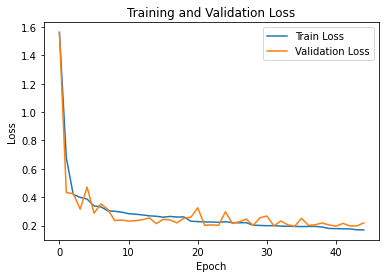

In [12]:
# Plotting training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'lstm_npulses_model_new_largeData_4.pth')

In [7]:
# Load the trained model
model.load_state_dict(torch.load('lstm_npulses_model_largeData_4.pth'))
model.eval()  # Set the model to evaluation mode

# Lists to store true and predicted values for pulses
true_pulses = []
predicted_pulses = []

# List to store the selected examples for visualization
selected_examples = []

# Iterate through the test data
for inputs, labels in test_dataloader:
    # Move data to the GPU
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get the predicted class (index with the highest probability)
    _, predicted = torch.max(outputs, 1)

    true_pulses.extend(labels.cpu().numpy())
    predicted_pulses.extend(predicted.cpu().numpy())

    # Append a tuple containing the input, true, and predicted labels to the selected_examples list
    selected_examples.extend(zip(inputs, labels, predicted))

# Visualize a select few examples
num_examples_to_visualize = 10  # Change this to the number of examples you want to visualize
for i, (input, true, predicted) in enumerate(selected_examples):
    if i < num_examples_to_visualize:
        image = input.cpu().numpy()
        true_count = decode_class(true)
        predicted_count = decode_class(predicted)

        # Plot the image
        plt.figure(figsize=(8, 4))
        plt.imshow(image, aspect='auto')
        plt.title(f"True: {true_count}, Predicted: {predicted_count}")
        plt.colorbar()
        plt.show()

# The true_pulses and predicted_pulses lists contain all predictions for the test set






NameError: name 'decode_class' is not defined

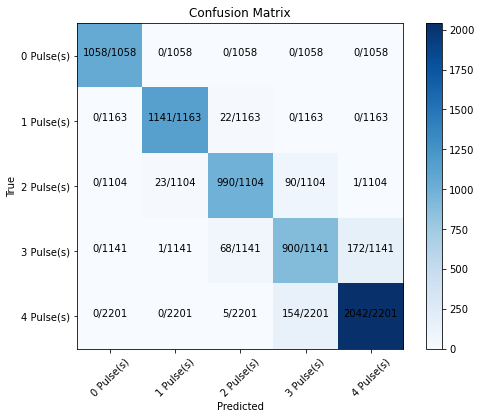

Accuracy: 0.9196
Precision: 0.9201
Recall: 0.9189
F1 Score: 0.9195
Class 0 - Accuracy: 1.0000
Class 1 - Accuracy: 0.9811
Class 2 - Accuracy: 0.8967
Class 3 - Accuracy: 0.7888
Class 4 - Accuracy: 0.9278


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Lists to store true and predicted values for pulses
true_pulses = []
predicted_pulses = []

# Iterate through the test data
for inputs, labels in test_dataloader:
    # Move data to the GPU
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get the predicted class (index with the highest probability)
    _, predicted = torch.max(outputs, 1)

    true_pulses.extend(labels.cpu().numpy())
    predicted_pulses.extend(predicted.cpu().numpy())

num_classes_fromTest = len(np.unique(true_pulses))
# Calculate evaluation metrics
accuracy = accuracy_score(true_pulses, predicted_pulses)
precision = precision_score(true_pulses, predicted_pulses, average='macro')
recall = recall_score(true_pulses, predicted_pulses, average='macro')
f1 = f1_score(true_pulses, predicted_pulses, average='macro')

# Confusion matrix
cm = confusion_matrix(true_pulses, predicted_pulses)



# Create class labels based on the number of classes
class_labels = [f'{i} Pulse(s)' for i in range(num_classes_fromTest)]

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))

# Add class labels to the plot
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

for i in range(num_classes_fromTest):
    for j in range(num_classes_fromTest):
        true_positive = cm[i, j]
        total_instances = cm[i].sum()
        text_label = f"{true_positive}/{total_instances}"
        plt.text(j, i, text_label, horizontalalignment="center", color="black")
# Add axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Display the plot
plt.show()

# # Compute the confusion matrix for each class
# for i in range(num_classes):
#     true_class = [1 if label == i else 0 for label in true_pulses]
#     predicted_class = [1 if label == i else 0 for label in predicted_pulses]
#     cm_class = confusion_matrix(true_class, predicted_class)
    
#     # Calculate accuracy for this class
#     accuracy_class = np.diag(cm_class).sum() / cm_class.sum()
    
#     class_name = f"Class {i+1}"
#     print(f"{class_name} - Accuracy: {accuracy_class:.10f}")
#     print(f"{class_name} - Confusion Matrix:")
#     print(cm_class)
# Print and display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
for i in range(num_classes_fromTest):
    true_positives = cm[i, i]  # The diagonal of the confusion matrix
    total_instances = np.sum(cm[i, :])  # Total instances in the true class
    accuracy_class = true_positives / total_instances

    class_name = f"Class {i}"
    print(f"{class_name} - Accuracy: {accuracy_class:.4f}")


In [ ]:
# Visualize the model architecture
from torchviz import make_dot
def plot_model_architecture(model, input_size):
    x = torch.randn(1, 1, input_size).to(device)  # Set the device for the input tensor
    y = model(x)
    vis_graph = make_dot(y, params=dict(model.named_parameters()))
    vis_graph.view()

# Plot the model architecture
plot_model_architecture(model, input_size)


In [109]:
model = PulseClassificationLSTM(input_size, hidden_size, num_classes, num_layers=2)

# Count the total number of parameters in the model
total_parameters = sum(p.numel() for p in model.parameters())

# Print the model attributes and total number of parameters
print("Model Attributes:")
print("------------------")
print("Total Parameters: {:}".format(total_parameters))
print("Number of Layers: {:}".format(len(list(model.parameters()))))
print()
print("Model Layers:")
print("------------------")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Size: {param.size()}")

Model Attributes:
------------------
Total Parameters: 242501
Number of Layers: 10

Model Layers:
------------------
Layer: lstm.weight_ih_l0, Size: torch.Size([256, 750])
Layer: lstm.weight_hh_l0, Size: torch.Size([256, 64])
Layer: lstm.bias_ih_l0, Size: torch.Size([256])
Layer: lstm.bias_hh_l0, Size: torch.Size([256])
Layer: lstm.weight_ih_l1, Size: torch.Size([256, 64])
Layer: lstm.weight_hh_l1, Size: torch.Size([256, 64])
Layer: lstm.bias_ih_l1, Size: torch.Size([256])
Layer: lstm.bias_hh_l1, Size: torch.Size([256])
Layer: fc.weight, Size: torch.Size([5, 64])
Layer: fc.bias, Size: torch.Size([5])


In [ ]:
# Binning and Results Visualization
# For all the right answers and for all the wrong answers bin the 2 and 3 and 4+ based on phase differences